# Graph the average of how many vehicles used each edge per driving strategy

Given a driving strategy, and set of valid simulation seeds, determine for each road segment how many vehicles used it to exit the evacuation zone. Compute the average of this per the number of seeds (unique simulation runs) given.

In [1]:
%matplotlib inline

In [209]:
# Import needed libraries
import os
import glob
import re
import pandas as pd
from FireABM_opt import *
print(shapely.__version__)

1.8.0


## Set Key Parameters

First, set key parameters - the timestep, strategy, and a list of valid seeds to plot. These will change to make different plots.

In [178]:
# set strategy: quickest, major, or dist
# strategy = "quickest"
strategies = ["quickest", "major", "dist"]
# set valid seeds
seeds = [4, 5] # (small set for testing)
# seeds = [4, 5, 6, 9, 12, 15, 16, 22, 25, 26, 28, 29, 30, 32, 33, 36, 38, 44, 47]

Next, set up less changing variables for the simulation. Determine output folder to store figures in:

In [179]:
# Set output folder name
out_folder = 'out_figures_camp'

Set the prefix for where the result files are stored:

In [180]:
# set result folder names and file start
result_prefix = "camp_fire_800_"
subfolder_name = "1trajs"
file_start = "result_file_0_"

## Gather Trajectory Data

Trajectory data is stored in the file with the result prefix followed by the strategy name, and then within the "1trajs" subfilder. This data is a list for each vehicle of each of the road segments taken during the evacuation.

First we can create a set of small functions. The first one parses input data from a trajectory string.

In [181]:
# return a list of edges used by a vehicle from a string list
in_traj_sample = "[((86405683, 86378529, 0), 0), ((86378529, 86405683, 0), 179), ('GOAL', 86405683, 179), ('GOAL', 86405683, None), ('GOAL', 86405683, None), ('GOAL', 86405683, None)]"
def parse_traj(in_traj):
    out_traj = re.findall('\(([^)]+)', in_traj)
    out_traj = [x[1:] for x in out_traj if x.split(",")[0] != "'GOAL'"]
    return(out_traj)

parse_traj(in_traj_sample)

['86405683, 86378529, 0', '86378529, 86405683, 0']

Then we have a small function to add a value to the dictionary of edges.

In [182]:
def increment_edge_dict(in_edge_dict, value):
    if value in in_edge_dict.keys():
        in_edge_dict[value] += 1
    else:
        in_edge_dict[value] = 1
        
    return(in_edge_dict)

sample_edge_dict = {}
sample_edge_dict["a"] = 1
sample_edge_dict = increment_edge_dict(sample_edge_dict, 'a')
sample_edge_dict = increment_edge_dict(sample_edge_dict, 'b')
sample_edge_dict = increment_edge_dict(sample_edge_dict, 'b')
print(sample_edge_dict)

{'a': 2, 'b': 2}


Finally, we can create a function to open a file, parse the directory, and increment the edge dictionary with the edge use frequeny.

In [183]:
def edge_freq_from_traj_per_seed(in_file_path):
    seed_edge_dict = {}
     
    with open(in_file_path) as f:
        content = f.readlines()
        for line in content:
            traj = line.split('\t')[1]
            edge_list = parse_traj(traj)
            for edge in edge_list:
                increment_edge_dict(seed_edge_dict, edge)
            
    return(seed_edge_dict)

## Iterate through seeds and driving strategies to calculate dictionaries of vehicle use per seed strategy combo

In [184]:
# create master edge dictionaries to hold all the results for seeds
# strategies: quickest, major, or dist
edge_dict_quickest = {}
edge_dict_major = {}
edge_dict_dist = {}

# iterate through strategies and seeds to assign edge use
for i, strat in enumerate(strategies):
    for j, seed in enumerate(seeds):
        print ("evaluating ", strat, " for seed ", seed)

        result_folder = result_prefix+strat
        file_path = glob.glob(os.path.join(result_folder, subfolder_name, file_start+str(seed)+'_*.txt'))[0]

        if strat == "quickest":
            edge_dict_quickest[seed] = edge_freq_from_traj_per_seed(file_path)
        elif strat == "major":
            edge_dict_major[seed] = edge_freq_from_traj_per_seed(file_path)
        elif strat == "dist":
            edge_dict_dist[seed] = edge_freq_from_traj_per_seed(file_path)
    
# sanity check output
print("sanity check")
# number of keys should all be the same
print(edge_dict_quickest.keys())
print(len(edge_dict_quickest.keys()))
print(edge_dict_major.keys())
print(len(edge_dict_major.keys()))
print(edge_dict_dist.keys())
print(len(edge_dict_dist.keys()))
# should be a generally high number of values per seed
print(len(edge_dict_quickest[seeds[0]]))
print(len(edge_dict_major[seeds[0]]))
print(len(edge_dict_dist[seeds[0]]))

evaluating  quickest  for seed  4
evaluating  quickest  for seed  5
evaluating  major  for seed  4
evaluating  major  for seed  5
evaluating  dist  for seed  4
evaluating  dist  for seed  5
sanity check
dict_keys([4, 5])
2
dict_keys([4, 5])
2
dict_keys([4, 5])
2
1616
1597
1613


## Load Road Graph

Here load the base road graph to use as a backrgound plot.

In [185]:
# Load road graph

road_graph_pkl = 'Paradise_fire_8000.pkl'
road_graph = load_road_graph(road_graph_pkl)
gdf_nodes, gdf_edges = get_node_edge_gdf(road_graph)
(bbox, lbbox, poly, x, y) = create_bboxes(gdf_nodes, 0.1,
                                          buff_adj=[2, 2.75, 2.5, 2.5])

## Add vehicle use to road graph edge data

Iterate through strategies and seeds to add new information to the graph.

In [186]:
# iterate through road segments
# if edge is in the dictionary, add it
# create column for strategy and seed

# iterate through strategies and seeds to assign edge use
for i, strat in enumerate(strategies):
    for j, seed in enumerate(seeds):
        print ("evaluating ", strat, " for seed ", seed)
        
        if strat == "quickest":
            for e in road_graph.edges(keys=True, data=True):
                edge_index = str(e[0])+", "+str(e[1])+", "+str(e[2])
                if edge_index in edge_dict_quickest[seed].keys():
                    e[3][strat+'_veh_for_sd_'+str(seed)] = edge_dict_quickest[seed][edge_index]
                else:
                    e[3][strat+'_veh_for_sd_'+str(seed)] = 0
            
        elif strat == "major":
            for e in road_graph.edges(keys=True, data=True):
                edge_index = str(e[0])+", "+str(e[1])+", "+str(e[2])
                if edge_index in edge_dict_major[seed].keys():
                    e[3][strat+'_veh_for_sd_'+str(seed)] = edge_dict_major[seed][edge_index]
                else:
                    e[3][strat+'_veh_for_sd_'+str(seed)] = 0
                    
        elif strat == "dist":
            for e in road_graph.edges(keys=True, data=True):
                edge_index = str(e[0])+", "+str(e[1])+", "+str(e[2])
                if edge_index in edge_dict_dist[seed].keys():
                    e[3][strat+'_veh_for_sd_'+str(seed)] = edge_dict_dist[seed][edge_index]
                else:
                    e[3][strat+'_veh_for_sd_'+str(seed)] = 0
        # output edges
        gdf_nodes, gdf_edges = get_node_edge_gdf(road_graph)
        
print("loop complete")

evaluating  quickest  for seed  4
evaluating  quickest  for seed  5
evaluating  major  for seed  4
evaluating  major  for seed  5
evaluating  dist  for seed  4
evaluating  dist  for seed  5
loop complete


Sanity check - look at some edges for different strategies and seeds.

In [187]:
# iterate through strategies and seeds to assign edge use
# expecting list to start with 300-400 vehicles on the highest edges
for i, strat in enumerate(strategies):
    for j, seed in enumerate(seeds):
        colum_name = strat+"_veh_for_sd_"+str(seed)
        print ("checking ", strat, " for seed ", seed, " col ", colum_name)
        if strat == "quickest":
            print(list(reversed(sorted(list(gdf_edges[colum_name]))))[0:10])
        elif strat == "major":
            print(list(reversed(sorted(list(gdf_edges[colum_name]))))[0:10])
        elif strat == "dist":
            print(list(reversed(sorted(list(gdf_edges[colum_name]))))[0:10])

checking  quickest  for seed  4  col  quickest_veh_for_sd_4
[340, 337, 323, 322, 308, 308, 201, 200, 200, 199]
checking  quickest  for seed  5  col  quickest_veh_for_sd_5
[358, 356, 349, 346, 338, 338, 265, 263, 263, 262]
checking  major  for seed  4  col  major_veh_for_sd_4
[357, 356, 356, 355, 355, 353, 353, 350, 350, 350]
checking  major  for seed  5  col  major_veh_for_sd_5
[386, 384, 384, 383, 382, 381, 380, 379, 378, 377]
checking  dist  for seed  4  col  dist_veh_for_sd_4
[404, 401, 387, 386, 372, 372, 186, 186, 185, 183]
checking  dist  for seed  5  col  dist_veh_for_sd_5
[405, 403, 396, 393, 385, 385, 208, 208, 208, 207]


# Divide graph edges into offset levels for plotting offsets

In [249]:
# Adjust geometry for reversed edges so both colors will show when plotted

In [250]:
edge_side_list = {}

for e in road_graph.edges(keys=True, data=True):
    edge_index = str(e[0])+", "+str(e[1])+", "+str(e[2])
    edge_side_list[e[0]] = [e[1], e[2]]
    e[3]['offset'] = "left"
    
# note some may have multi matches
for e in road_graph.edges(keys=True, data=True):
    if e[1] in edge_side_list.keys():
        if edge_side_list[e[1]][0] == e[0]:
            e[3]['offset'] = "right"
            e[3]["geometry"] = e[3]["geometry"].parallel_offset(15)

# output edges
gdf_nodes, gdf_edges = get_node_edge_gdf(road_graph)
set(gdf_edges['offset'])

{'left', 'right'}

## Find the average vehicle per edge per driving strategy, create 3 new columns

In [251]:
# create column list per strategy (strat + seed)
# add a new column with average per strat + seed combo to gdf_edges
# export
# repeat

# create column list for strategy
for i, strat in enumerate(strategies):
    colum_list = []
    for j, seed in enumerate(seeds):
        colum_name = strat+"_veh_for_sd_"+str(seed)
        colum_list.append(colum_name)
    print(colum_list)
    ave_colum_name = strat+"_ave_edge_veh"
    gdf_edges[ave_colum_name] = gdf_edges[colum_list].mean(axis=1)
    
print("averaging complete")

['quickest_veh_for_sd_4', 'quickest_veh_for_sd_5']
['major_veh_for_sd_4', 'major_veh_for_sd_5']
['dist_veh_for_sd_4', 'dist_veh_for_sd_5']
averaging complete


Sanity check that averaging completed correctly

In [252]:
# iterate through strategies and seeds to assign edge use
# expecting list to start with 300-400 vehicles on the highest edges for average (compare to above for rough)
for i, strat in enumerate(strategies):
    colum_name = strat+"_ave_edge_veh"
    print ("checking ", strat," col ", colum_name)
    if strat == "quickest":
        print(list(reversed(sorted(list(gdf_edges[colum_name]))))[0:10])
    elif strat == "major":
        print(list(reversed(sorted(list(gdf_edges[colum_name]))))[0:10])
    elif strat == "dist":
        print(list(reversed(sorted(list(gdf_edges[colum_name]))))[0:10])

checking  quickest  col  quickest_ave_edge_veh
[349.0, 346.5, 336.0, 334.0, 323.0, 323.0, 233.0, 231.5, 231.5, 230.5]
checking  major  col  major_ave_edge_veh
[371.5, 370.0, 370.0, 369.0, 368.5, 367.0, 366.5, 364.5, 364.0, 363.5]
checking  dist  col  dist_ave_edge_veh
[404.5, 402.0, 391.5, 389.5, 378.5, 378.5, 197.0, 197.0, 196.5, 194.5]


Add result back to road graph

In [253]:
for e in road_graph.edges(keys=True, data=True):
    for i, strat in enumerate(strategies):
        colum_name = strat+"_ave_edge_veh"
        e[3][colum_name] = gdf_edges.loc[(e[0], e[1], e[2]), :][colum_name]
print("loop complete")

loop complete


## Calculate difference in average edge use

In [270]:
# subtract average values from each other
gdf_edges["d-q_ave_edge_veh"] = gdf_edges["dist_ave_edge_veh"] - gdf_edges["quickest_ave_edge_veh"]
gdf_edges["q-d_ave_edge_veh"] = gdf_edges["quickest_ave_edge_veh"] - gdf_edges["dist_ave_edge_veh"]
gdf_edges["q-m_ave_edge_veh"] = gdf_edges["quickest_ave_edge_veh"] - gdf_edges["major_ave_edge_veh"]
gdf_edges["d-m_ave_edge_veh"] = gdf_edges["dist_ave_edge_veh"] - gdf_edges["major_ave_edge_veh"]
gdf_edges["m-q_ave_edge_veh"] = gdf_edges["major_ave_edge_veh"] - gdf_edges["quickest_ave_edge_veh"]
gdf_edges["m-d_ave_edge_veh"] = gdf_edges["major_ave_edge_veh"] - gdf_edges["dist_ave_edge_veh"]


# Plot edge concentration

## Quickest

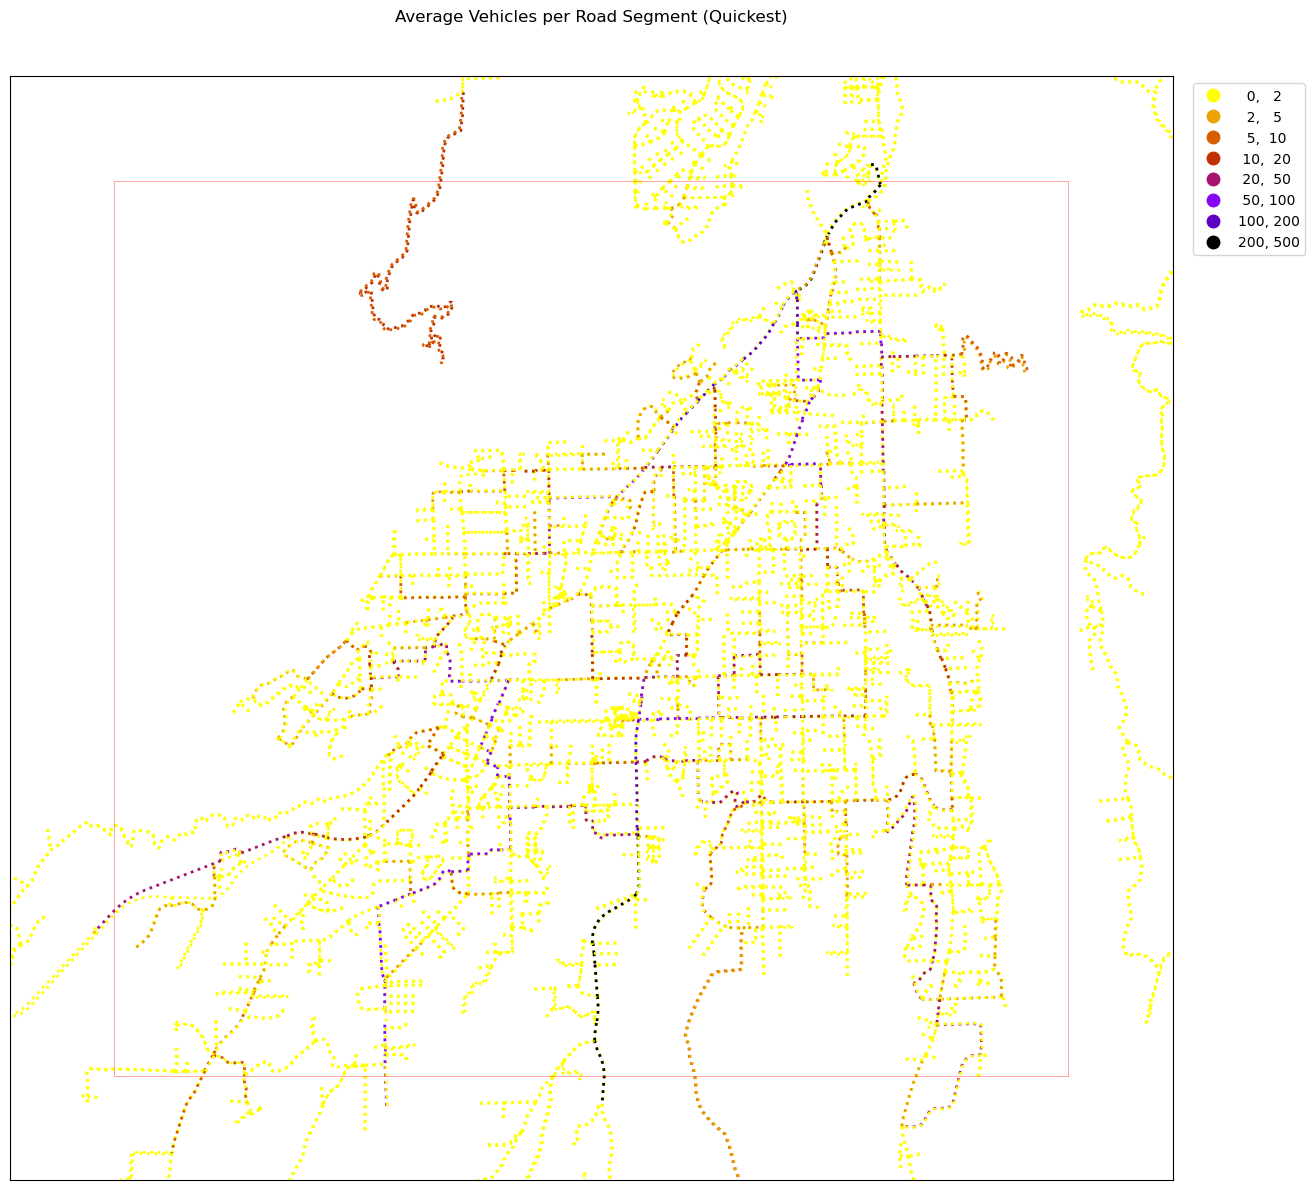

In [271]:
# plot average vehicles for quickest
fig, ax = plt.subplots(figsize=(15, 15))

gdf_edges.plot(column='quickest_ave_edge_veh', cmap='gnuplot_r', scheme="User_Defined", linewidth=2,linestyle='dotted',
         legend=True, classification_kwds=dict(bins=[2,5,10,20,50,100,200,500]),
         ax=ax, legend_kwds={'bbox_to_anchor': (1.12, 1), 'fmt':'{:.0f}'})

ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
title = ax.text(0.5, 1.05, "Average Vehicles per Road Segment (Quickest)",
                size=plt.rcParams["axes.titlesize"],
                ha="center", transform=ax.transAxes)
boundln, = ax.plot(x, y, color='red', alpha=0.5, linewidth=0.5, solid_capstyle='round', zorder=2)

plt.savefig(os.path.join(out_folder, 'vehicles_per_seg_quickest.pdf'), format='pdf')
plt.show()

## Shortest Distance

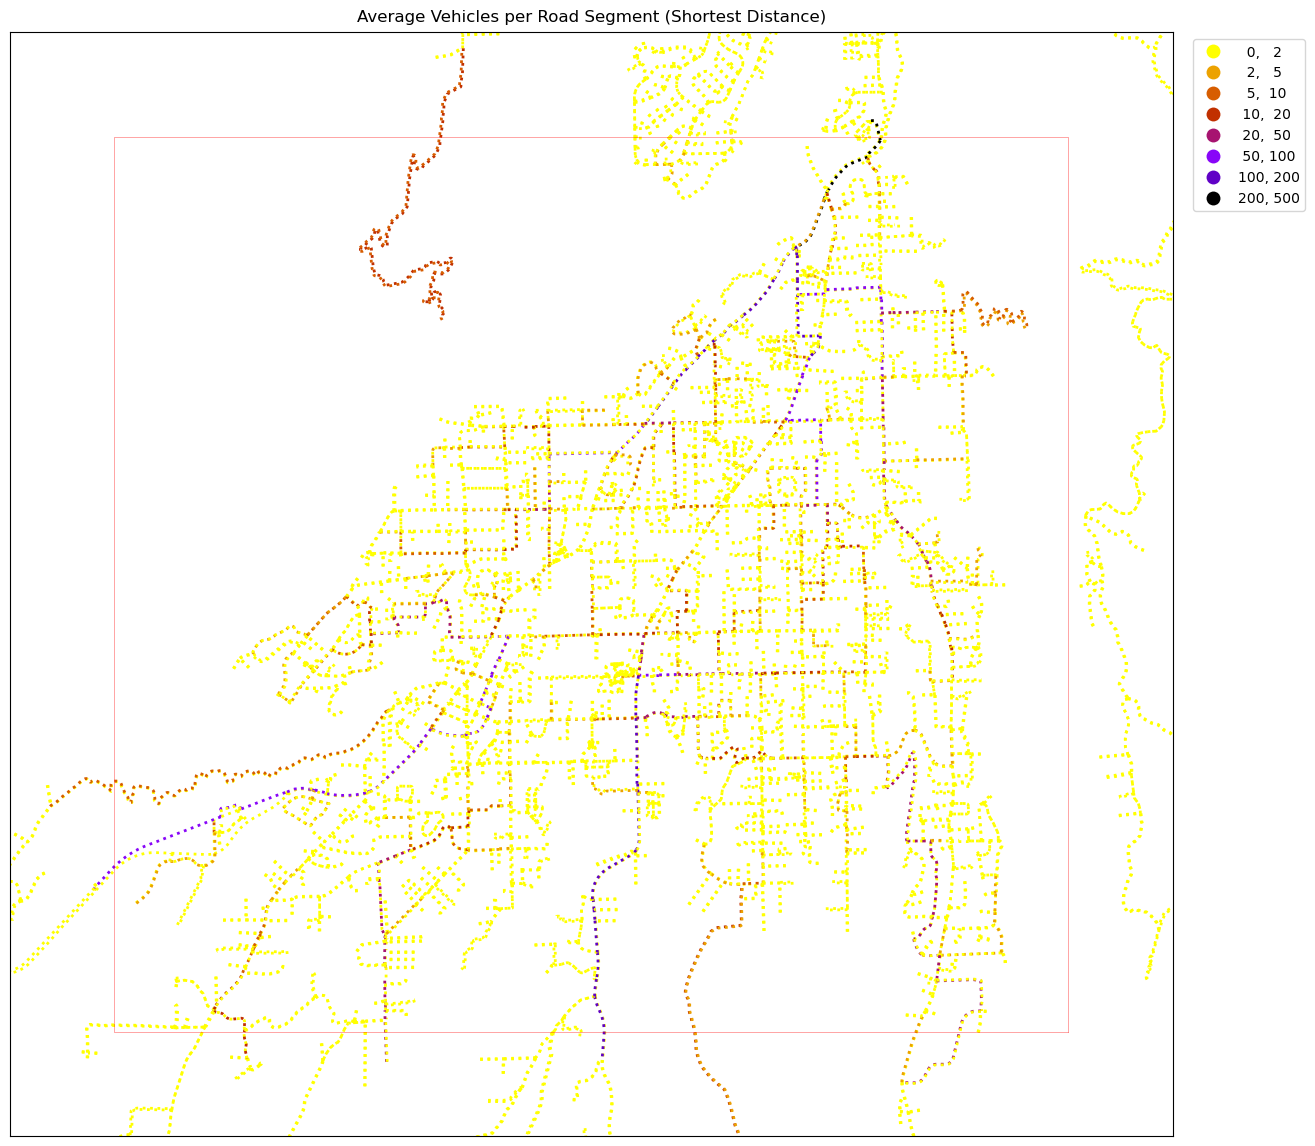

In [272]:
# plot average vehicles for shortest distance
fig, ax = plt.subplots(figsize=(15, 15))

gdf_edges.plot(column='dist_ave_edge_veh', cmap='gnuplot_r', scheme="User_Defined", linewidth=2,linestyle='dotted',
         legend=True, classification_kwds=dict(bins=[2,5,10,20,50,100,200,500]),
         ax=ax, legend_kwds={'bbox_to_anchor': (1.12, 1), 'fmt':'{:.0f}'})

ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
title = ax.text(0.5, 1.01, "Average Vehicles per Road Segment (Shortest Distance)",
                size=plt.rcParams["axes.titlesize"],
                ha="center", transform=ax.transAxes)
boundln, = ax.plot(x, y, color='red', alpha=0.5, linewidth=0.5, solid_capstyle='round', zorder=2)

plt.savefig(os.path.join(out_folder, 'vehicles_per_seg_dist.pdf'), format='pdf')
plt.show()

## Major Roads

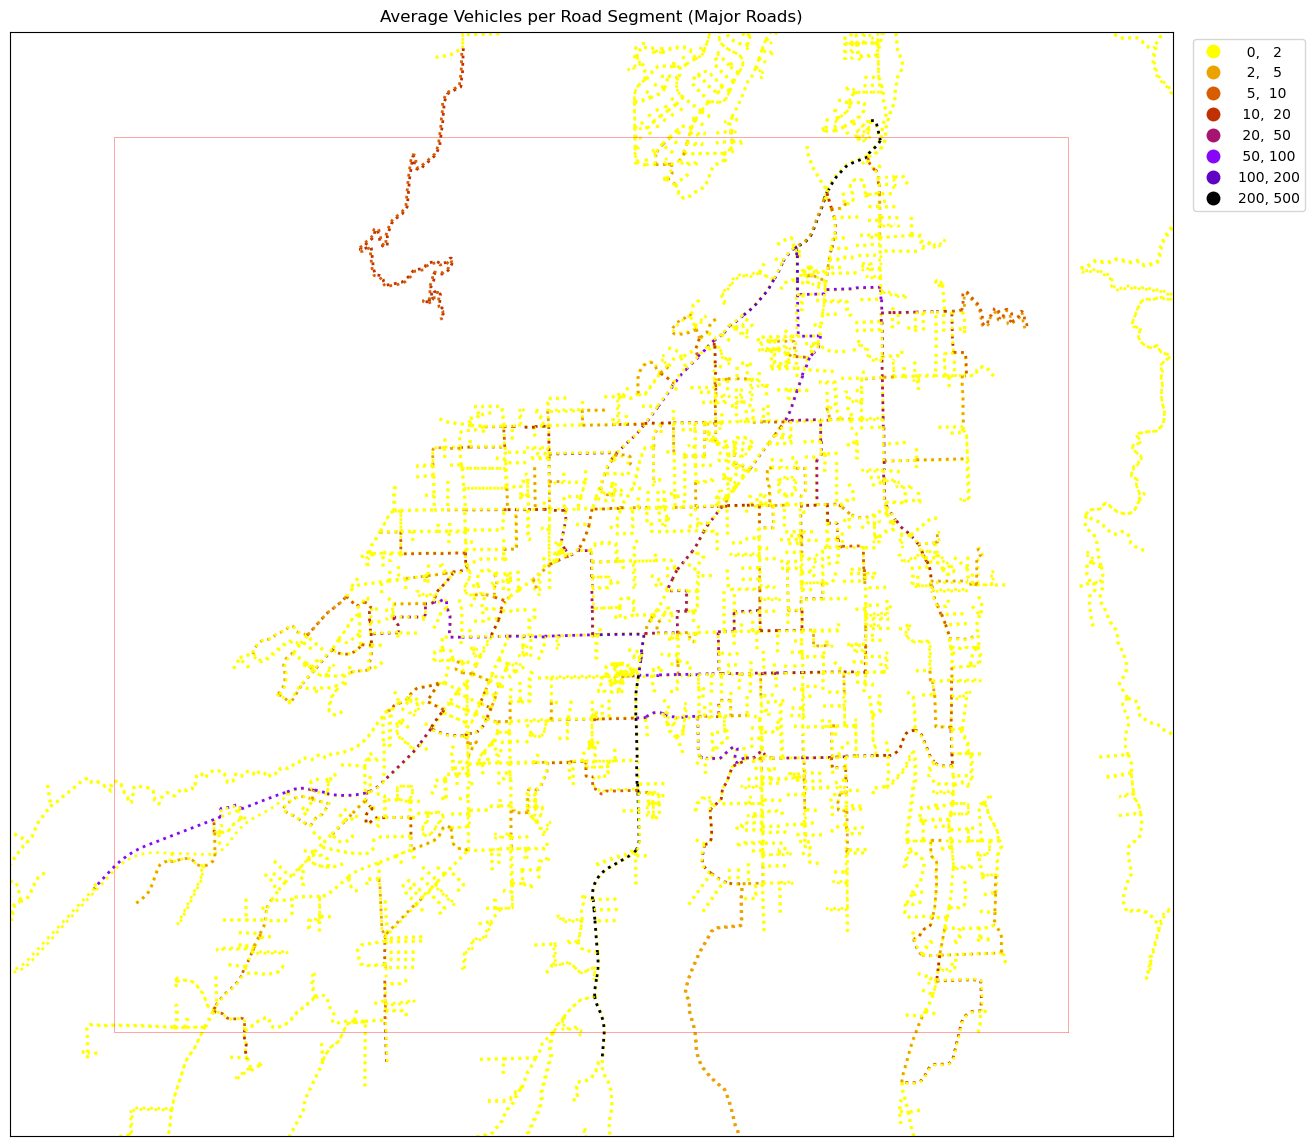

In [273]:
# plot average vehicles for major roads
fig, ax = plt.subplots(figsize=(15, 15))

gdf_edges.plot(column='major_ave_edge_veh', cmap='gnuplot_r', scheme="User_Defined", linewidth=2,linestyle='dotted',
         legend=True, classification_kwds=dict(bins=[2,5,10,20,50,100,200,500]),
         ax=ax, legend_kwds={'bbox_to_anchor': (1.12, 1), 'fmt':'{:.0f}'})

ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
title = ax.text(0.5, 1.01, "Average Vehicles per Road Segment (Major Roads)",
                size=plt.rcParams["axes.titlesize"],
                ha="center", transform=ax.transAxes)
boundln, = ax.plot(x, y, color='red', alpha=0.5, linewidth=0.5, solid_capstyle='round', zorder=2)

plt.savefig(os.path.join(out_folder, 'vehicles_per_seg_major.pdf'), format='pdf')
plt.show()

# Plot difference in edge concentration

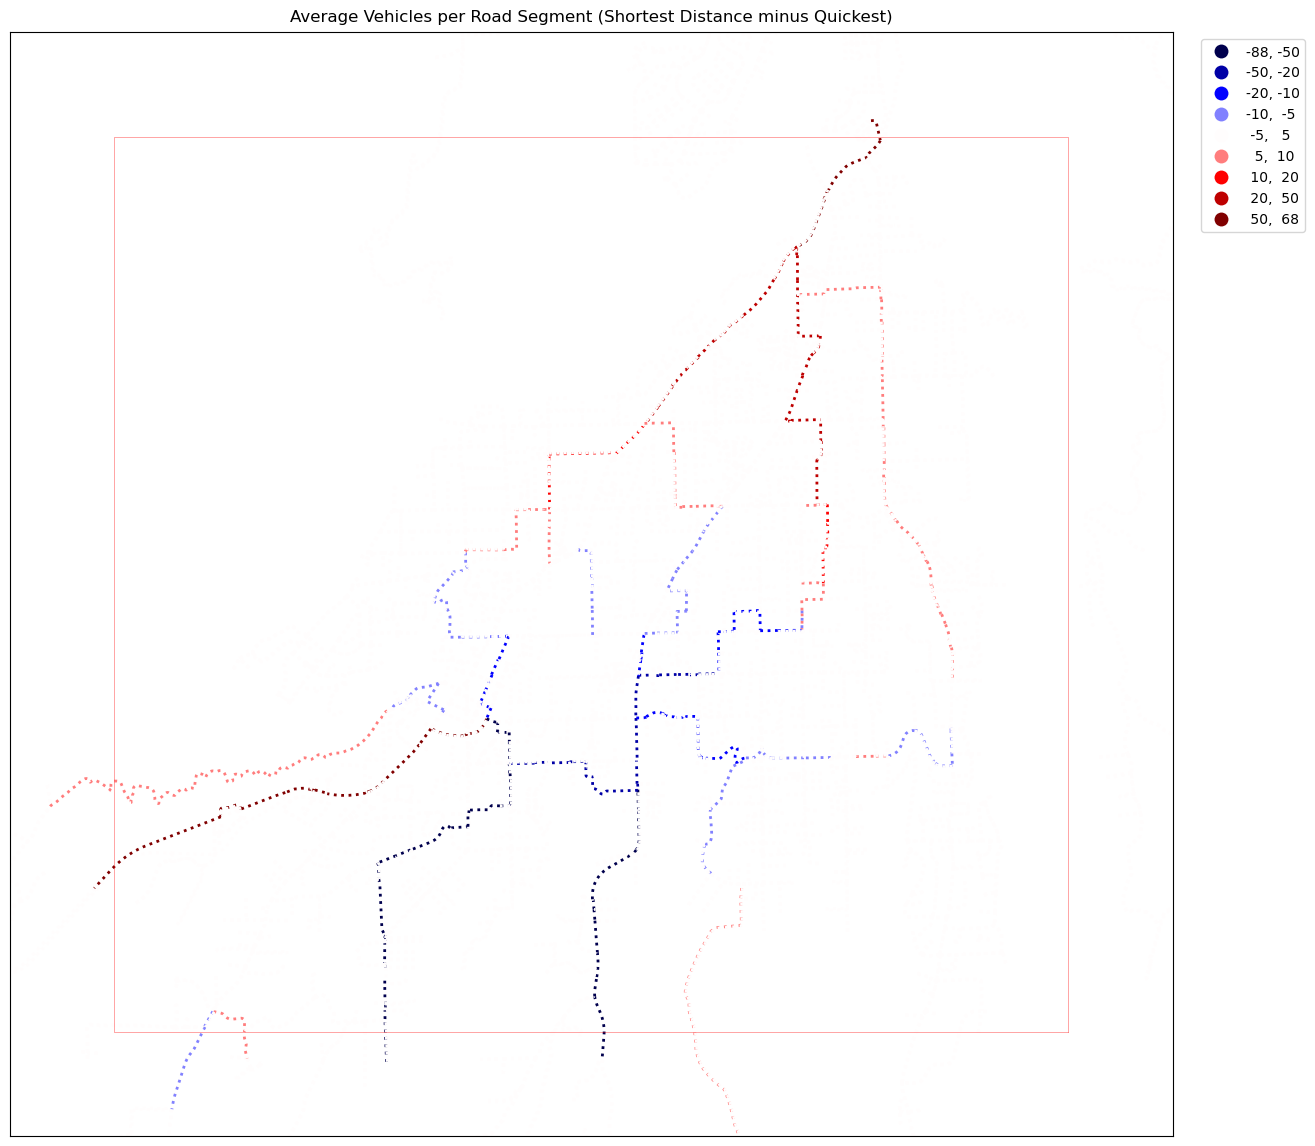

In [274]:
# plot average vehicles for quickest minus shortest distance
fig, ax = plt.subplots(figsize=(15, 15))

gdf_edges.plot(column='d-q_ave_edge_veh', cmap='seismic', scheme="User_Defined", linewidth=2, linestyle='dotted',
         legend=True, classification_kwds=dict(bins=[-50, -20, -10, -5, 5, 10, 20, 50]),
         # legend=True, classification_kwds=dict(bins=[-200, -100, -50, -20, -10, -5, 5, 10, 20, 50, 100, 200, np.inf]),
         ax=ax, legend_kwds={'bbox_to_anchor': (1.12, 1), 'fmt':'{:.0f}', }) # 'labels': ["-100, 50","-100, 50", "-100, 50", "-100, 50", "-100, 50"]

ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
title = ax.text(0.5, 1.01, "Average Vehicles per Road Segment (Shortest Distance minus Quickest)",
                size=plt.rcParams["axes.titlesize"],
                ha="center", transform=ax.transAxes)
boundln, = ax.plot(x, y, color='red', alpha=0.5, linewidth=0.5, solid_capstyle='round', zorder=2,)

plt.savefig(os.path.join(out_folder, 'vehicles_per_seg_d-q.pdf'), format='pdf')
plt.show()

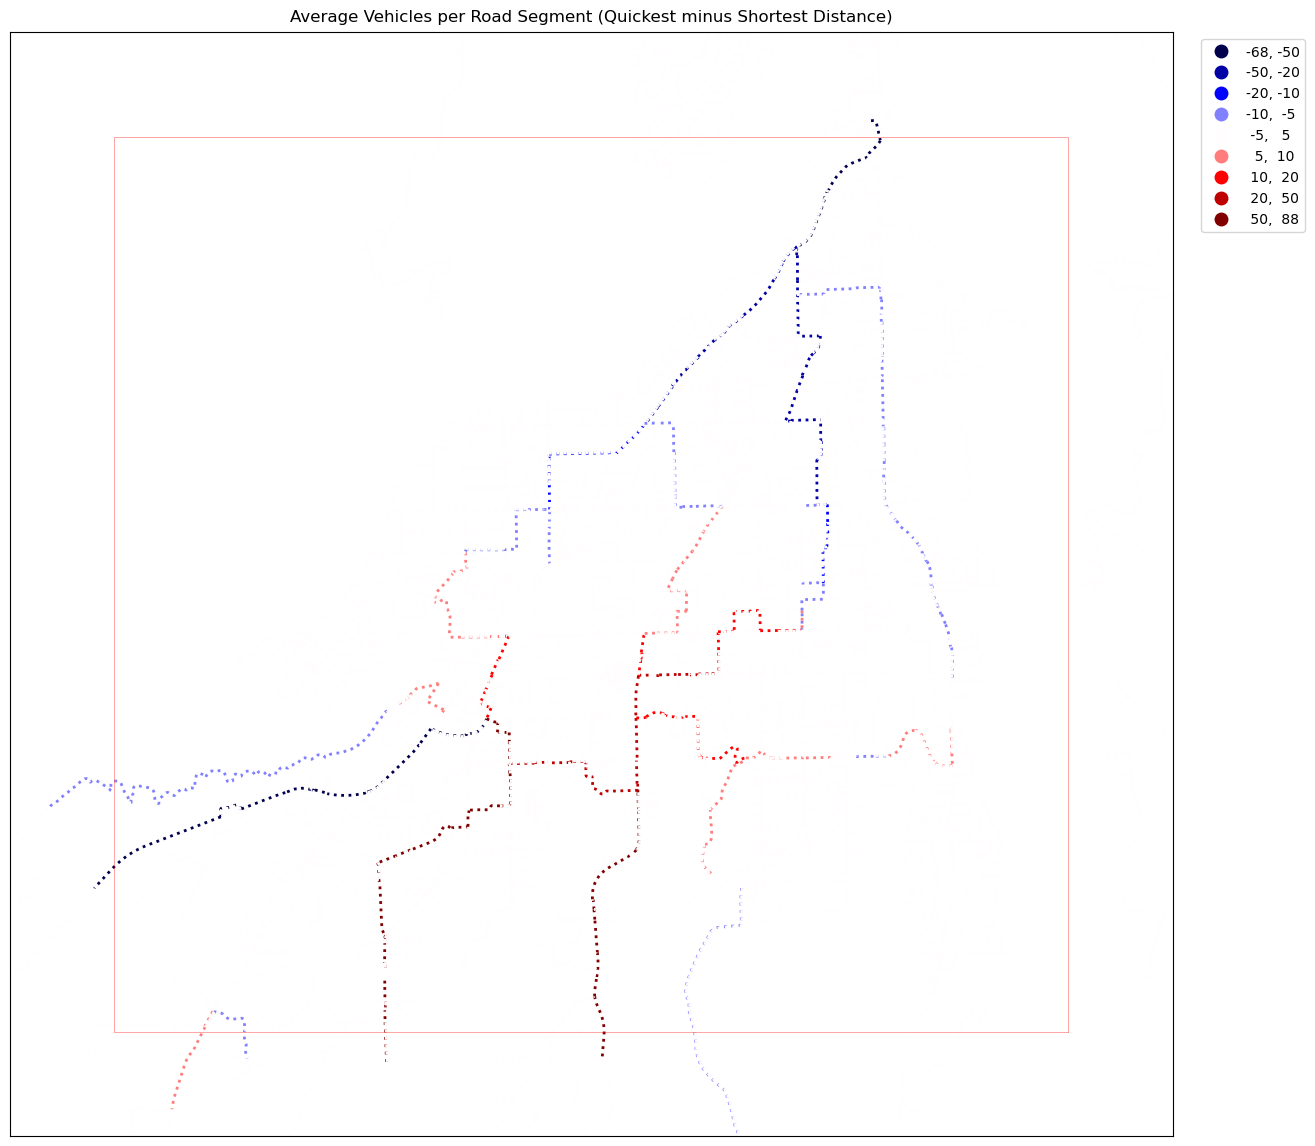

In [281]:
# plot average vehicles for quickest minus shortest distance
fig, ax = plt.subplots(figsize=(15, 15))

gdf_edges.plot(column='q-d_ave_edge_veh', cmap='seismic', scheme="User_Defined", linewidth=2, linestyle='dotted',
         legend=True, classification_kwds=dict(bins=[-50, -20, -10, -5, 5, 10, 20, 50]),
         # legend=True, classification_kwds=dict(bins=[-200, -100, -50, -20, -10, -5, 5, 10, 20, 50, 100, 200, np.inf]),
         ax=ax, legend_kwds={'bbox_to_anchor': (1.12, 1), 'fmt':'{:.0f}', }) # 'labels': ["-100, 50","-100, 50", "-100, 50", "-100, 50", "-100, 50"]

ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
title = ax.text(0.5, 1.01, "Average Vehicles per Road Segment (Quickest minus Shortest Distance)",
                size=plt.rcParams["axes.titlesize"],
                ha="center", transform=ax.transAxes)
boundln, = ax.plot(x, y, color='red', alpha=0.5, linewidth=0.5, solid_capstyle='round', zorder=2,)

plt.savefig(os.path.join(out_folder, 'vehicles_per_seg_q-d.pdf'), format='pdf')
plt.show()

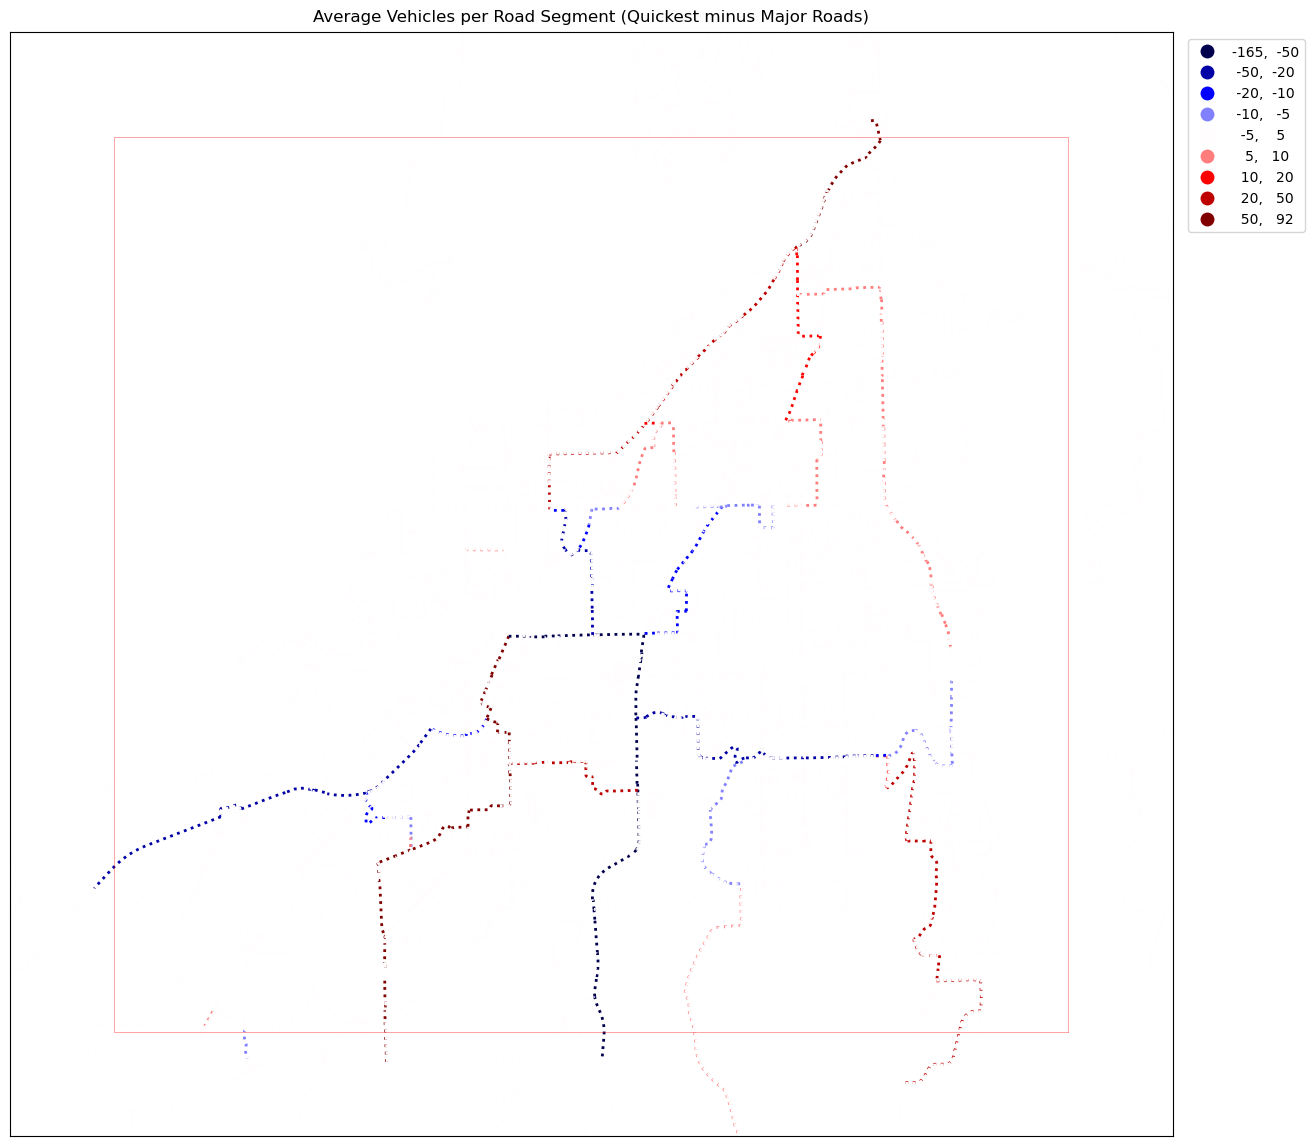

In [276]:
# plot average vehicles for quickest minus shortest distance
fig, ax = plt.subplots(figsize=(15, 15))

gdf_edges.plot(column='q-m_ave_edge_veh', cmap='seismic', scheme="User_Defined", linewidth=2,linestyle='dotted',
         legend=True, classification_kwds=dict(bins=[-50, -20, -10, -5, 5, 10, 20, 50]),
         ax=ax, legend_kwds={'bbox_to_anchor': (1.12, 1), 'fmt':'{:.0f}'})

ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
title = ax.text(0.5, 1.01, "Average Vehicles per Road Segment (Quickest minus Major Roads)",
                size=plt.rcParams["axes.titlesize"],
                ha="center", transform=ax.transAxes)
boundln, = ax.plot(x, y, color='red', alpha=0.5, linewidth=0.5, solid_capstyle='round', zorder=2)

plt.savefig(os.path.join(out_folder, 'vehicles_per_seg_q-m.pdf'), format='pdf')
plt.show()

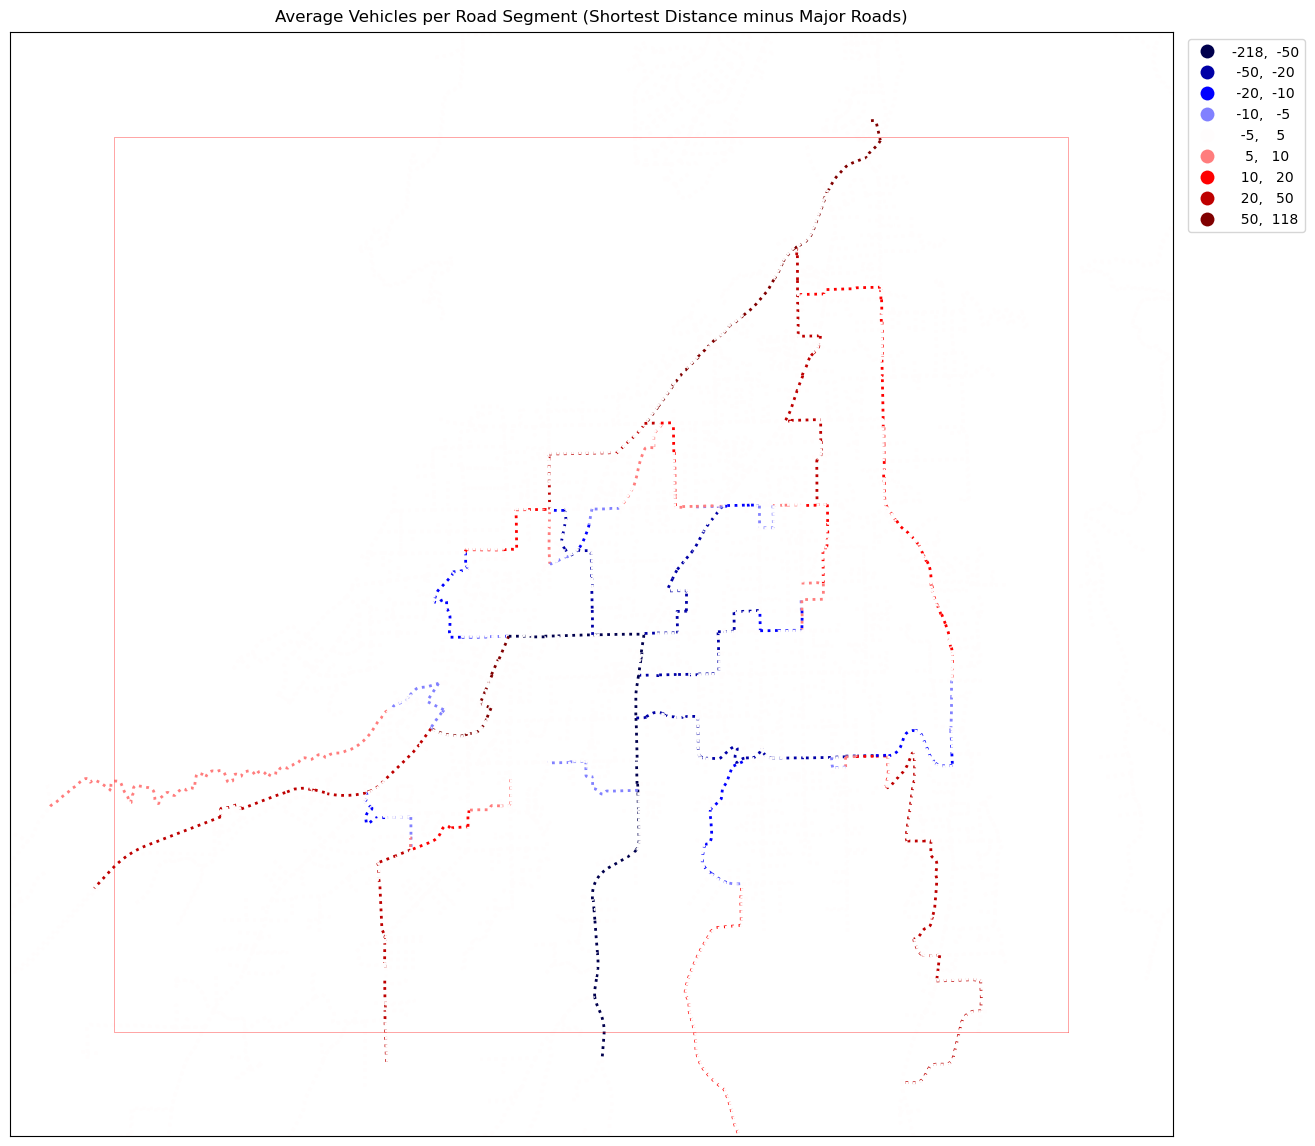

In [277]:
# plot average vehicles for quickest minus shortest distance
fig, ax = plt.subplots(figsize=(15, 15))

gdf_edges.plot(column='d-m_ave_edge_veh', cmap='seismic', scheme="User_Defined", linewidth=2,linestyle='dotted',
         legend=True, classification_kwds=dict(bins=[-50, -20, -10, -5, 5, 10, 20, 50]),
         ax=ax, legend_kwds={'bbox_to_anchor': (1.12, 1), 'fmt':'{:.0f}'})

ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
title = ax.text(0.5, 1.01, "Average Vehicles per Road Segment (Shortest Distance minus Major Roads)",
                size=plt.rcParams["axes.titlesize"],
                ha="center", transform=ax.transAxes)
boundln, = ax.plot(x, y, color='red', alpha=0.5, linewidth=0.5, solid_capstyle='round', zorder=2)

plt.savefig(os.path.join(out_folder, 'vehicles_per_seg_d-m.pdf'), format='pdf')
plt.show()

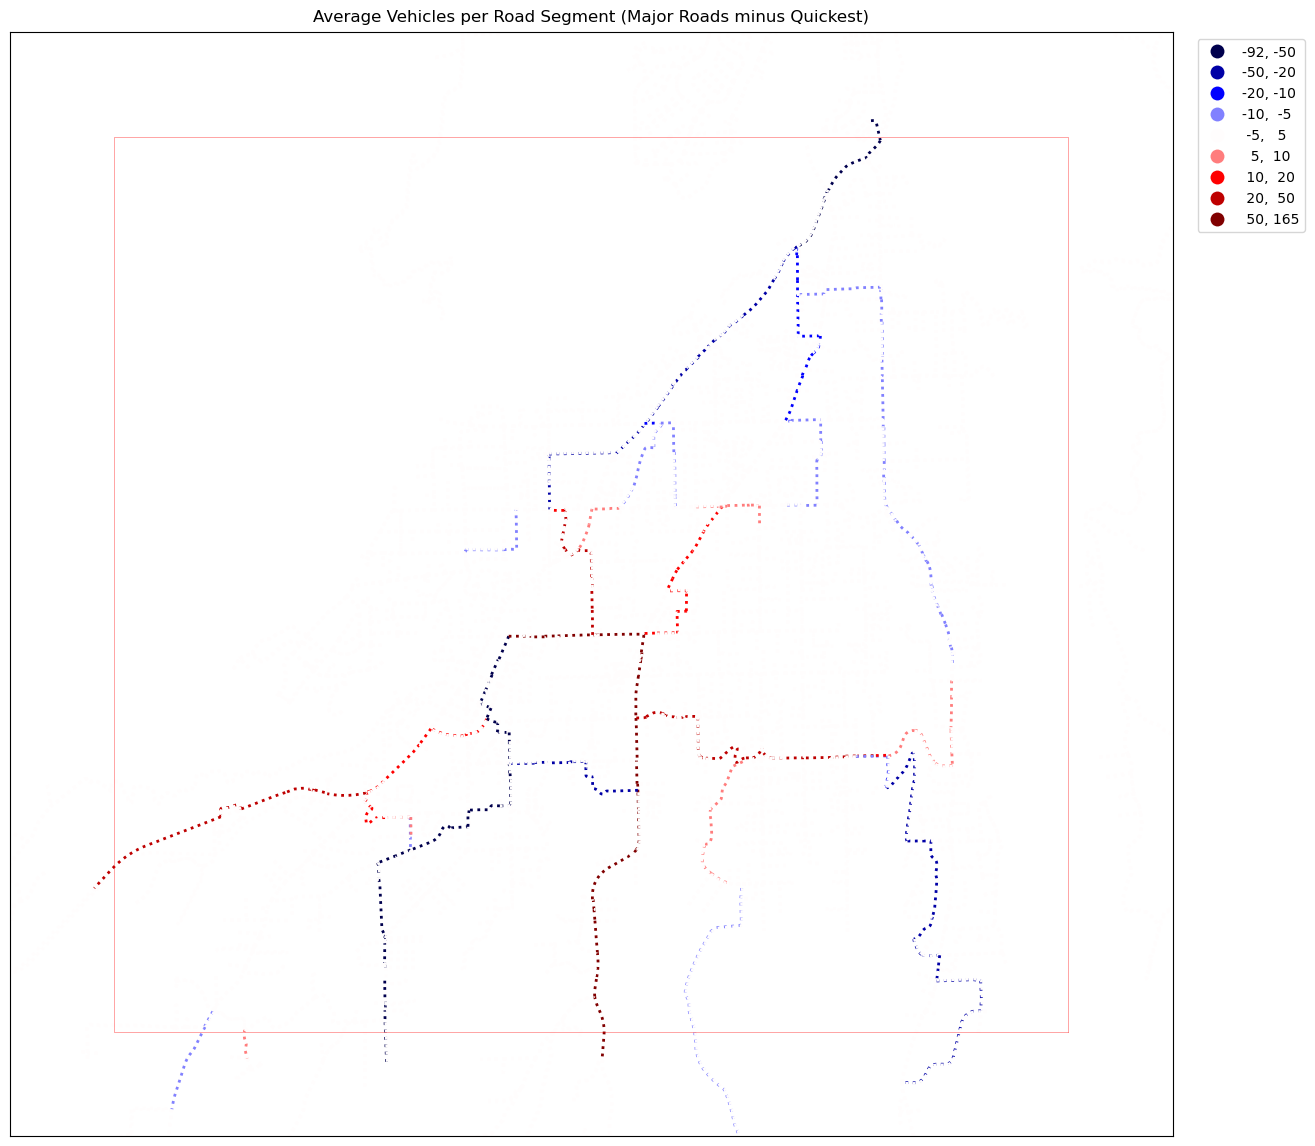

In [278]:
# plot average vehicles for quickest minus shortest distance
fig, ax = plt.subplots(figsize=(15, 15))

gdf_edges.plot(column='m-q_ave_edge_veh', cmap='seismic', scheme="User_Defined", linewidth=2,linestyle='dotted',
         legend=True, classification_kwds=dict(bins=[-50, -20, -10, -5, 5, 10, 20, 50]),
         ax=ax, legend_kwds={'bbox_to_anchor': (1.12, 1), 'fmt':'{:.0f}'})

ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
title = ax.text(0.5, 1.01, "Average Vehicles per Road Segment (Major Roads minus Quickest)",
                size=plt.rcParams["axes.titlesize"],
                ha="center", transform=ax.transAxes)
boundln, = ax.plot(x, y, color='red', alpha=0.5, linewidth=0.5, solid_capstyle='round', zorder=2)

plt.savefig(os.path.join(out_folder, 'vehicles_per_seg_m-q.pdf'), format='pdf')
plt.show()

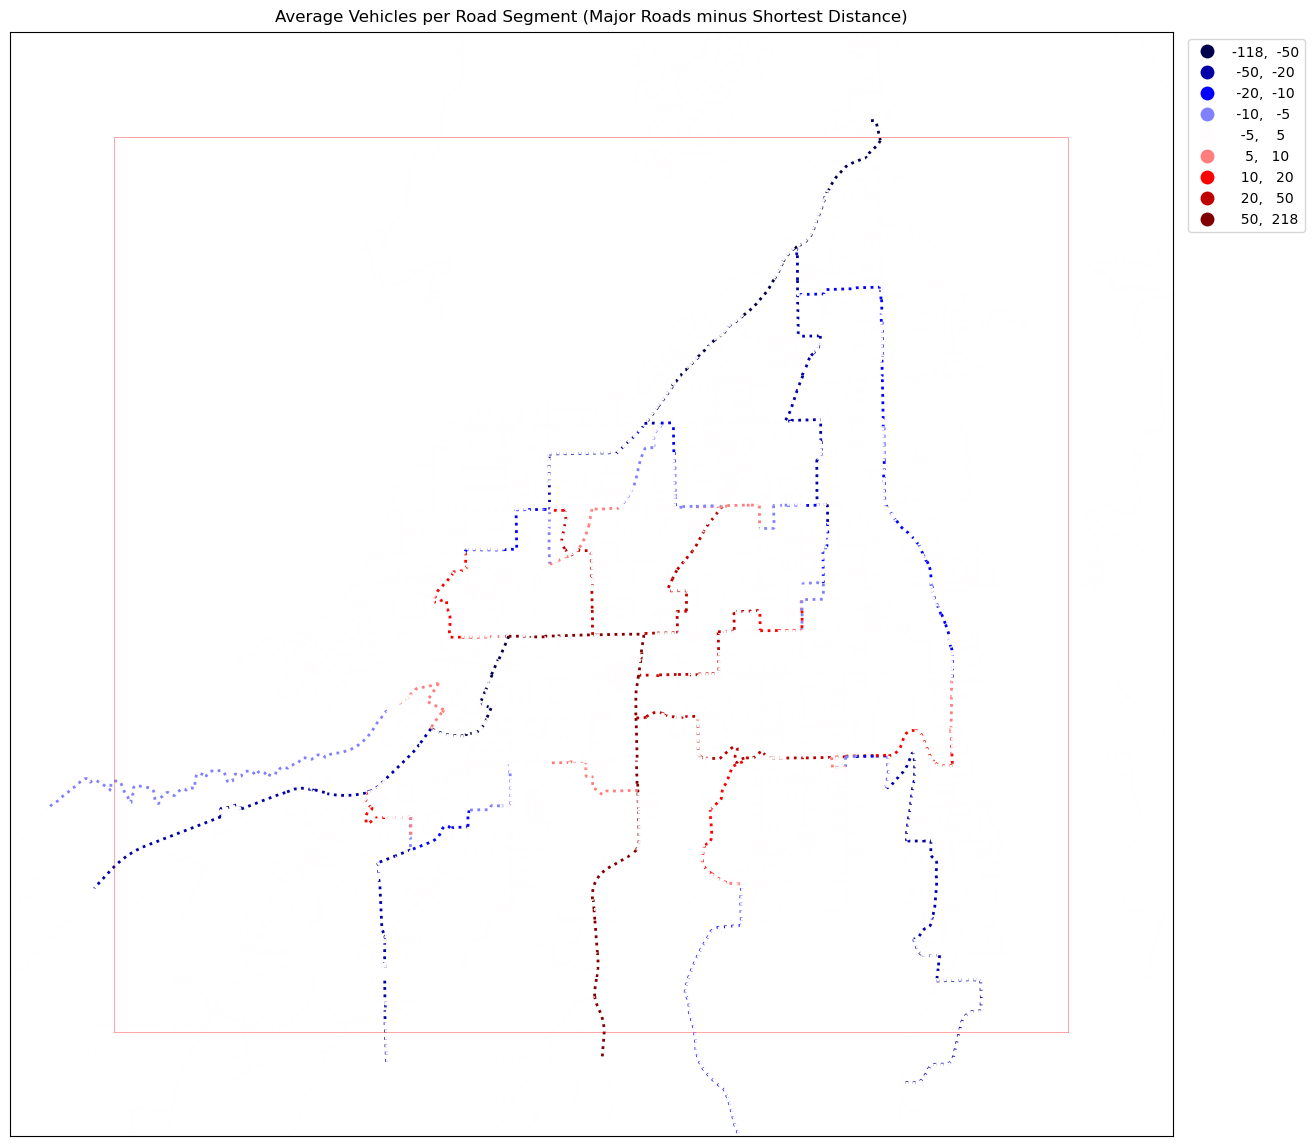

In [279]:
# plot average vehicles for quickest minus shortest distance
fig, ax = plt.subplots(figsize=(15, 15))

gdf_edges.plot(column='m-d_ave_edge_veh', cmap='seismic', scheme="User_Defined", linewidth=2,linestyle='dotted',
         legend=True, classification_kwds=dict(bins=[-50, -20, -10, -5, 5, 10, 20, 50]),
         ax=ax, legend_kwds={'bbox_to_anchor': (1.12, 1), 'fmt':'{:.0f}'})

ax.set_xlim(min(x)-1000, max(x)+1000)
ax.set_ylim(min(y)-1000, max(y)+1000)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
title = ax.text(0.5, 1.01, "Average Vehicles per Road Segment (Major Roads minus Shortest Distance)",
                size=plt.rcParams["axes.titlesize"],
                ha="center", transform=ax.transAxes)
boundln, = ax.plot(x, y, color='red', alpha=0.5, linewidth=0.5, solid_capstyle='round', zorder=2)


plt.savefig(os.path.join(out_folder, 'vehicles_per_seg_m-d.pdf'), format='pdf')
plt.show()